In [1]:
__file__ = "sharingBicycle_solution.ipynb"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pytest
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
import ipytest.magics
import glob

In [3]:
class BicycleSharingAnalysis(object):
        
    def barplot(self, x, y, df, figname):
        # plot average feature y based on feature x
        # x: feature on x axis
        # y: feature on y axis
        # figname: figure name
        sns.barplot(x=x, y=y, data=df, ci=None)
        plt.ylabel("Count of Total Rental Bikes")
        plt.savefig(figname+".pdf", bbox_inches='tight')
    
    def diff_day_type_hour_plot(self, df_hour, season_name, season_num):
        # plot average hourly count curve for working day weekend and holiday for a given season
        # df_hour: dataframe
        # season_name: string, season name
        # season_num: int, the number stands for the season
        df_hour_spring = df_hour[df_hour["season"] == season_num]
        sns.set_style("whitegrid")
        sns.lineplot(x="hr", y="cnt", data=df_hour_spring[df_hour_spring["workingday"]==1], ci = None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour_spring[(df_hour_spring["weekday"]==0) | (df_hour_spring["weekday"]==6)], ci = None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour_spring[df_hour_spring["holiday"]==1], ci = None, marker="o")
        # plt.title("Average of Bicycle Hourly Utilization")
        plt.xlabel("Hour (0-23)")
        plt.legend(["working day", "weekend", "holiday"])
        plt.ylabel("Count of Total Rental Bikes")
        plt.title(season_name)
        plt.xticks(np.arange(24, step=1));
        plt.savefig(season_name+"_curve.pdf", bbox_inches='tight')
    
    def season_curve_plot(self, df_hour):
        # plot average hourly count curve for each season
        # df_hour: dataframe
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["season"]==1], ci=None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["season"]==2], ci=None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["season"]==3], ci=None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["season"]==4], ci=None, marker="o")
        plt.xlabel("Hour (0-23)")
        plt.ylabel("Count of Total Rental Bikes")
        plt.legend(["Spring", "Summer", "Fall", "Winter"])
        plt.xticks(np.arange(24, step=1));
        plt.savefig("season_curve.pdf", bbox_inches='tight')
    
    def weekday_hour_curve_plot(self, df_hour):
        # plot average hourly count curves for each weekday
        # df_hour: dataframe contains hourly data
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["weekday"]==0], ci=None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["weekday"]==1], ci=None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["weekday"]==2], ci=None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["weekday"]==3], ci=None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["weekday"]==4], ci=None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["weekday"]==5], ci=None, marker="o")
        sns.lineplot(x="hr", y="cnt", data=df_hour[df_hour["weekday"]==6], ci=None, marker="o")
        plt.xlabel("Hour (0-23)")
        plt.ylabel("Count of Total Rental Bikes")
        plt.legend(["Sunday", "Monday", "Tuesday", "Wensday", "Thursday", "Friday", "Saturday"])
        plt.xticks(np.arange(24, step=1));
        plt.savefig("weekday_curve.pdf", bbox_inches='tight')
    
    def correlation_map(self, df, features):
        # plot a correlation map
        # df: dataframe
        # features: list of features
        corrmat = df[features].corr()
        mask = np.array(corrmat)
        mask[np.triu_indices_from(mask)] = False
        ax = sns.heatmap(data=corrmat, mask = mask, annot=True, square=True)
        plt.yticks(rotation=0)
        ax.set_xlim(0,np.size(features))
        ax.set_ylim(0,np.size(features))
        plt.savefig("correlation_map.pdf", bbox_inches='tight')
        
    def feature_drop(self, df, name, axis):
        # drop fatures
        # name: name of features
        # axis: axis, 0, 1
        df = df.drop(name, axis = axis)
        return df
        
    def feature_engineering(self, df):
        # split season feature to binary features and add weekend features
        
        n = np.shape(df)[0]
        season_1 = np.zeros(n)
        season_2 = np.zeros(n)
        season_3 = np.zeros(n)
        season_4 = np.zeros(n)
        season_1[df["season"] == 1] = 1
        season_2[df["season"] == 2] = 1
        season_3[df["season"] == 3] = 1
        season_4[df["season"] == 4] = 1
        
        df = df.drop(["season"], axis=1)
        
        df.insert(loc=1, column="season_1", value=season_1)
        df.insert(loc=1, column="season_2", value=season_2)
        df.insert(loc=1, column="season_3", value=season_3)
        df.insert(loc=1, column="season_4", value=season_4)
        
        n = np.shape(df)[0]
        weekend = np.zeros(n)
        weekend[(df["holiday"]==0) & (df["workingday"]==0)]=1
        
        df.insert(loc=1, column="weekend", value=weekend)
        
        return df

In [4]:
df_hour = pd.read_csv("Bike-Sharing-Dataset/hour.csv")

In [5]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
df_hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [36]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## Model

### Drop features

In [46]:
df = BicycleSharingAnalysis().feature_drop(df_hour, ["instant", "casual", "registered", "dteday"], 1)

In [47]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


## Convert to binary features and add features

In [48]:
df = BicycleSharingAnalysis().feature_engineering(df)

In [49]:
df.head()

,yr,weekend,season_4,season_3,season_2,season_1,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,0,1.0,0.0,0.0,0.0,1.0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,0,1.0,0.0,0.0,0.0,1.0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,0,1.0,0.0,0.0,0.0,1.0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,0,1.0,0.0,0.0,0.0,1.0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,0,1.0,0.0,0.0,0.0,1.0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [50]:
n = np.shape(df)[1]
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:n-1], df.iloc[:, n-1], random_state=42)
reg = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=300)
reg.fit(X_train, y_train)
predict = reg.predict(X_test)
mae = mean_absolute_error(y_test, predict)
print("mae: ", mae)

mae:  25.47349002685079


## Tests

============================= test session starts ==============================
platform linux -- Python 3.7.3, pytest-5.0.1, py-1.8.0, pluggy-0.12.0
rootdir: /home/kai/Projects/Sharing_Bicycle
collected 1 item

sharingBicycle_solution.py .                                             [100%]

=============================== warnings summary ===============================
sharingBicycle_solution.py::test_analysis
sharingBicycle_solution.py::test_analysis
  /home/kai/miniconda3/envs/sharing_bicycle/lib/python3.7/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning: 
  The label function will be deprecated in a future version. Use Tick.label1 instead.
    fontsize = tick.label.get_size()

-- Docs: https://docs.pytest.org/en/latest/warnings.html
===================== 1 passed, 2 warnings in 2.56 seconds =====================


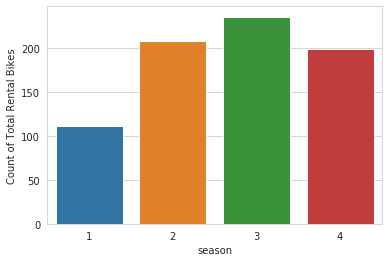

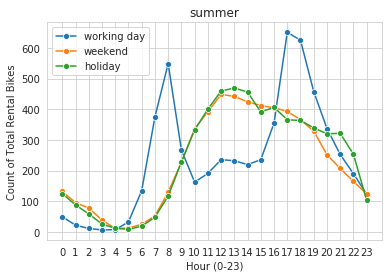

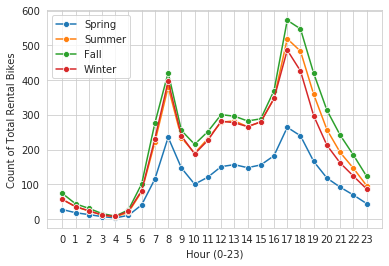

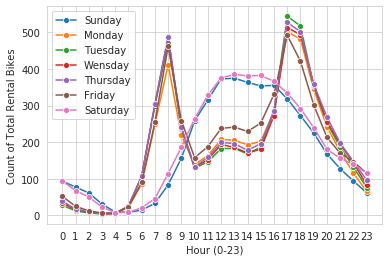

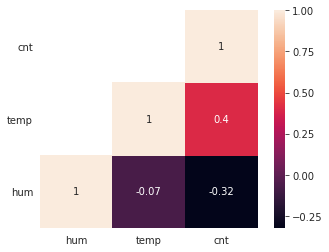

In [123]:
%%run_pytest

@pytest.fixture
def config():
    df = pd.read_csv("Bike-Sharing-Dataset/hour.csv")
    return df

def test_analysis(config, a = BicycleSharingAnalysis()):
    plt.figure()
    a.barplot("season", "cnt", config, "a")
    plt.figure()
    a.diff_day_type_hour_plot(config, "summer", 3)
    plt.figure()
    a.season_curve_plot(config)
    plt.figure()
    a.weekday_hour_curve_plot(config)
    plt.figure()
    a.correlation_map(config, ["hum", "temp", "cnt"])
    
    ls = glob.glob("*.pdf")
    num = np.size(ls)
    
    n = np.shape(config)[1]
    res1 = a.feature_drop(config, "instant",1)
    n1 = np.shape(res1)[1]
    res2 = a.feature_engineering(config)
    n2 = np.shape(res2)[1]
    
    assert num == 5, "Plots do not work as expected"
    assert n1 == n-1, "Feature drop do not work as expected"
    assert n2 == n+5, "Feature engineering do not work as expected"    